# BERT attention heads

Going deeper on the BERT representations.

See:  
https://huggingface.co/transformers/bertology.html

From Clark et al's analysis of BERT's attention heads:  
https://www-nlp.stanford.edu/pubs/clark2019what.pdf

![title](data/coref_head.png)

Let's see if we can grab head 5-4 and confirm this pattern of attention.

In [1]:
import torch
from transformers import *

# All the classes for an architecture can be initiated from pretrained weights for this architecture
# Note that additional weights added for fine-tuning are only initialized
# and need to be trained on the down-stream task
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

# Models can return full list of hidden-states & attentions weights at each layer
model = BertModel.from_pretrained(pretrained_weights,
                                  output_hidden_states=True,
                                  output_attentions=True)

model.eval();

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


### Use BertViz
https://github.com/jessevig/bertviz

**important**: need to install this package. Run this one directory up from the notebook:

`git clone https://github.com/jessevig/bertviz bertviz_repo`


In [12]:
# Set notebook up to run files from the BertViz repo
import os
import sys
module_path = os.path.abspath(os.path.join('../bertviz_repo'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from bertviz import head_view

### Load Transformer class

In [3]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

foo = TransformerRSM("pieman", verbose=False, model_name='bert-base-uncased')

Looking for TR-aligned tokens in data/stimuli/pieman/tr_tokens.csv
Loaded 277 TRs.


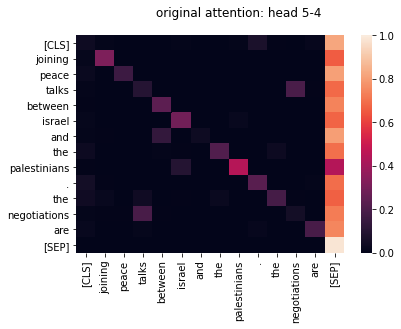

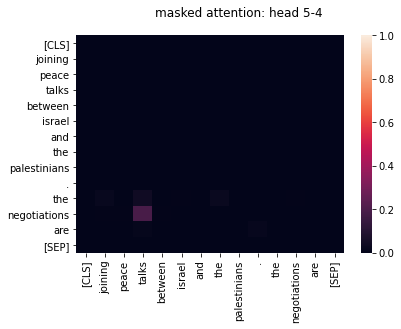

In [31]:
# Use the sentence from the paper:
string_to_test = "joining peace talks between Israel and the Palestinians. The negotiations are"

input_ids = torch.tensor([tokenizer.encode(string_to_test, add_special_tokens=True)])
all_hidden_states, all_attentions = model(input_ids)[-2:]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

layer_number = 4
head_number = 3

head = all_attentions[layer_number][0][head_number]
masked = foo._mask_head_attention(head, 3).numpy()

sns.heatmap(pd.DataFrame(head.detach().numpy()), xticklabels=tokens, yticklabels=tokens, vmin=0,vmax=1)
plt.suptitle("original attention: head {}-{}".format(layer_number+1, head_number+1))

plt.figure()
sns.heatmap(pd.DataFrame(masked), xticklabels=tokens, yticklabels=tokens, vmin=0,vmax=1)
plt.suptitle("masked attention: head {}-{}".format(layer_number+1, head_number+1));

# Attention Analyses

In [5]:
foo.verbose = False
foo.process_stimulus_attentions()

In [6]:
foo.stimulus_df.attentions_transformer_tokens

0              [[CLS], i, began, my, illustrious, [SEP]]
1      [[CLS], i, began, my, illustrious, career, in,...
2      [[CLS], i, began, my, illustrious, career, in,...
3      [[CLS], i, began, my, illustrious, career, in,...
4      [my, illustrious, career, in, journalism, in, ...
                             ...                        
272    [the, guy, out, of, costume, so, i, looked, at...
273    [so, i, looked, at, her, and, i, said, yes, an...
274    [her, and, i, said, yes, angela, i, am, pie, m...
275    [yes, angela, i, am, pie, man, and, she, said,...
276    [am, pie, man, and, she, said, oh, good, now, ...
Name: attentions_transformer_tokens, Length: 277, dtype: object

In [7]:
foo.process_stimulus_activations()

Processed 277 TRs for activations.


In [8]:
foo.stimulus_df.columns

Index(['tr', 'start_ts', 'end_ts', 'tr.1', 'tokens', 'n_tokens', 'tr_shift',
       'prev_tr', 'attentions', 'attentions_transformer_tokens', 'activations',
       'transformer_tokens_in_tr', 'n_transformer_tokens_in_tr'],
      dtype='object')

In [9]:
# What's the 90th percentile of tokens-per-
foo.stimulus_df.n_transformer_tokens_in_tr.quantile(.90)

7.0

In [10]:
foo.mask_non_tr_attentions()

In [14]:
# Grab attentions for a random TR
head_view_tr = 100

head_view_masked_attentions = foo.stimulus_df.masked_attentions[head_view_tr]
head_view_attentions = foo.stimulus_df.attentions[head_view_tr]
head_view_tokens = foo.stimulus_df.attentions_transformer_tokens[head_view_tr]

# head_view([h.unsqueeze(0) for h in head_view_attentions], head_view_tokens)
head_view([h.unsqueeze(0) for h in head_view_masked_attentions], head_view_tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p=2)
foo.compute_attention_head_magnitudes(p='inf')

moment and then i say dean mc ##go ##wan would you care to comment on this latest attack and [SEP]
cape ##less and said that as he fled the scene he clicked his heels in ra ##kis ##h glee [SEP]
enough out comes sheila beale student body president and now sheila was different from me and all the other [SEP]
the next day which ran with a photo of him leaving the scene cape flowing behind him doing this [SEP]
by the way she said it i knew that if i said yes she would have sex with me [SEP]
i had never seen the guy out of costume so i looked at her and i said yes angela [SEP]


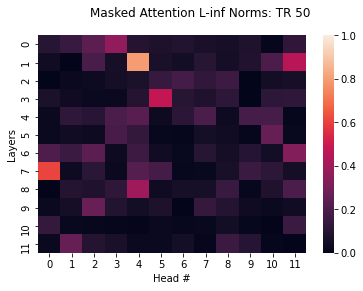

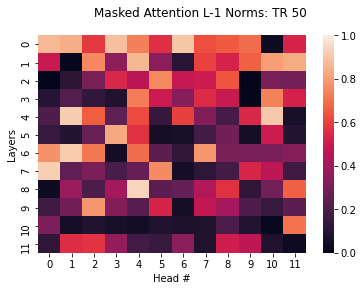

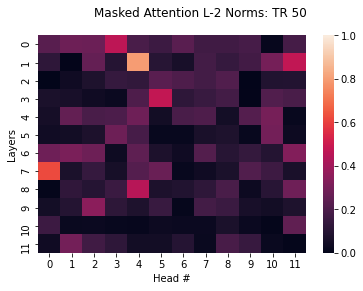

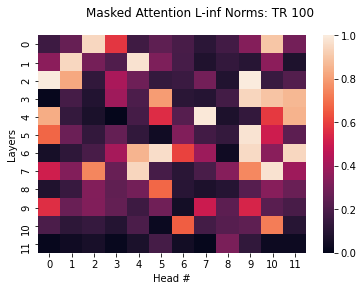

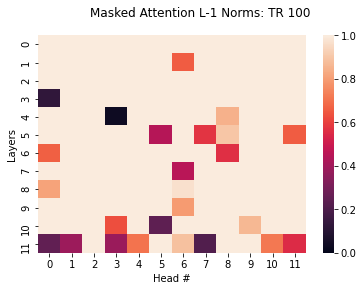

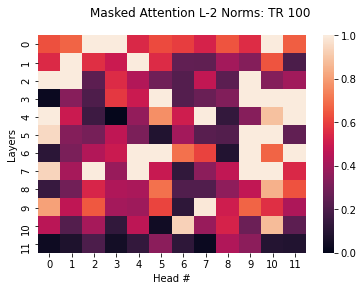

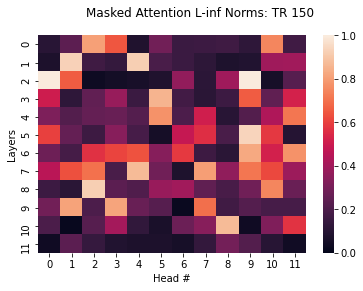

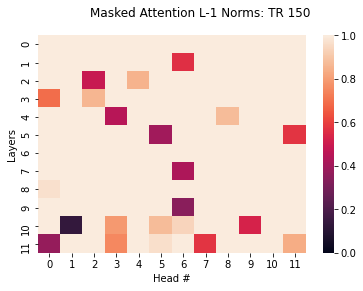

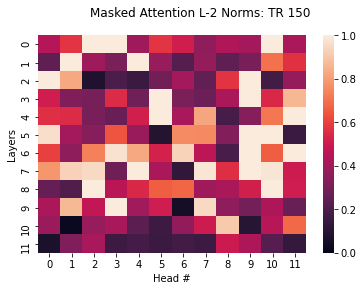

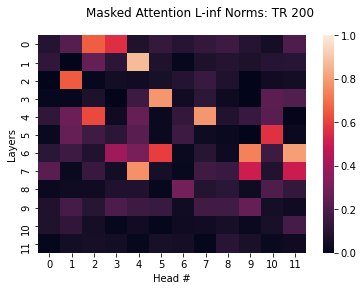

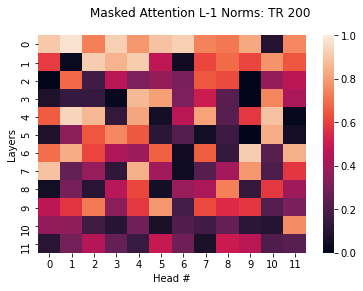

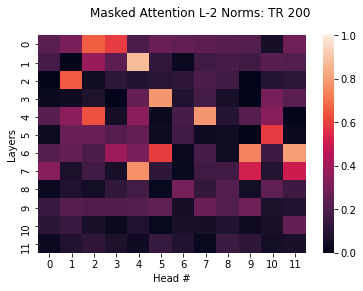

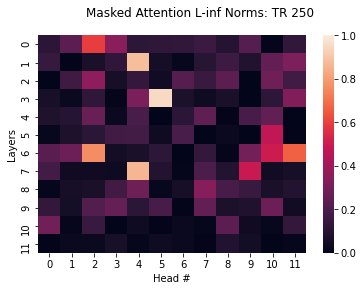

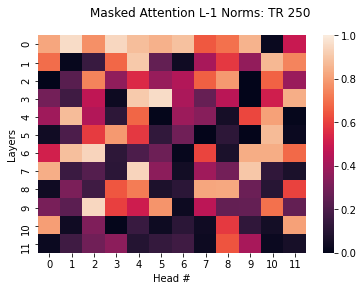

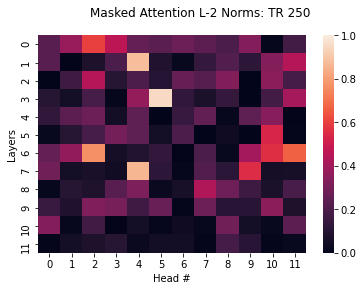

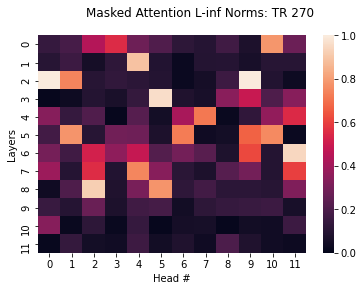

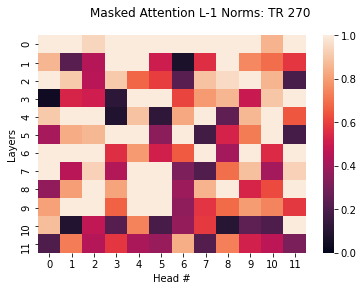

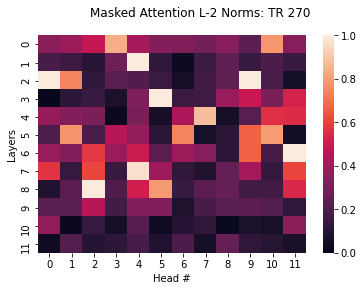

In [16]:
# Look at L-inf activations for a few sentences
norms = ['inf', 1, 2]
trs = [50, 100, 150, 200, 250, 270]

for tr in trs:
    tr_tokens = " ".join(foo.stimulus_df.iloc[tr].attentions_transformer_tokens)
    print(tr_tokens)
    
    for p in norms:
        plt.figure()
        sns.heatmap(pd.DataFrame(foo.stimulus_df.iloc[tr]["attention_heads_L{}".format(p)]), vmin=0, vmax=1)

        plt.xlabel("Head #")
        plt.ylabel("Layers")
        
        info = "Masked Attention L-{} Norms: TR {}".format(p, tr)
        plt.suptitle("{}".format(info))
    

## TRs with the highest "coreference" head activations

Applies to BERT-base only!

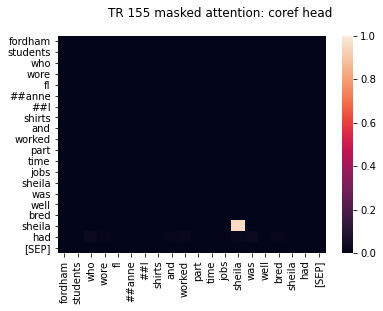

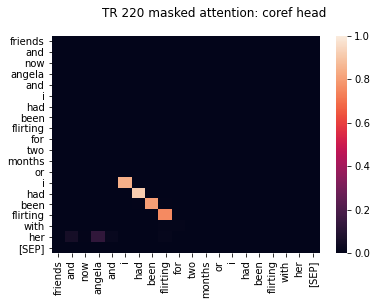

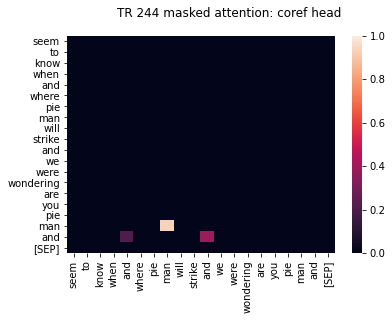

In [17]:
# Define and apply function to extract the max-magnitude of the "Coref" head activations in this TR

def get_coref_magnitude(heads):
    if heads is None:
        return None
    return heads[4][3]

if foo.model_name == "bert-base-uncased":

    foo.stimulus_df["coref_mag"] = foo.stimulus_df.attention_heads_Linf.apply(lambda x: get_coref_magnitude(x))

    coref_rows = foo.stimulus_df[foo.stimulus_df["coref_mag"] > .9]

    for i, c in coref_rows.iterrows():

        plt.figure()
        sns.heatmap(pd.DataFrame(c["masked_attentions"][4][3].numpy()), 
                    xticklabels=c.attentions_transformer_tokens, 
                    yticklabels=c.attentions_transformer_tokens, 
                    vmin=0,vmax=1)

        plt.suptitle("TR {} masked attention: coref head".format(i))


# "Attention Effects"

### End-to-end
How far do tokens "move in space" from the initial embeddings to final outputs?

`activation_end_to_end_l2_distances[n_token]` gives the start-to-finish displacement of the contextualization process. Longer distances indicates the token's meaning was changed more during contextualization.

In [18]:
foo.verbose=False
foo.process_stimulus_activations()

Processed 277 TRs for activations.


In [19]:
import numpy as np
foo.end_to_end_token_movement()

def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

foo.stimulus_df["activation_end_to_end_mean_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_max_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))

foo.stimulus_df.activation_end_to_end_mean_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_mean_l2)
foo.stimulus_df.activation_end_to_end_max_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_max_l2)

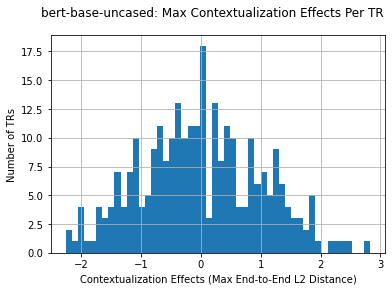

In [20]:
foo.stimulus_df.activation_end_to_end_max_l2.hist(bins=50)
plt.suptitle("{}: Max Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Max End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

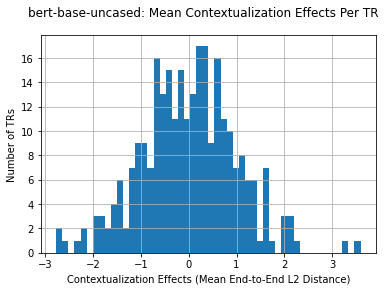

In [21]:
foo.stimulus_df.activation_end_to_end_mean_l2.hist(bins=50)
plt.suptitle("{}: Mean Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Mean End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

### Layerwise
How far do tokens move each layer?

`activation_layerwise_l2_distances[n_layer][n_token]` gives the L2 distance that each token moved, each layer.

We can look at the mean or max distance for each layer + token.

In [22]:
foo.layerwise_token_movement()

len(foo.stimulus_df["activation_layerwise_l2_distances"][0][0])

4

In [23]:
mean_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.mean(layer) for layer in x])
max_l2_per_layer = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.max(layer) for layer in x])

foo.stimulus_df["activation_layerwise_mean_l2"] = mean_l2_per_layer
foo.stimulus_df["activation_layerwise_max_l2"] = max_l2_per_layer

['so', 'i', 'race', 'back']


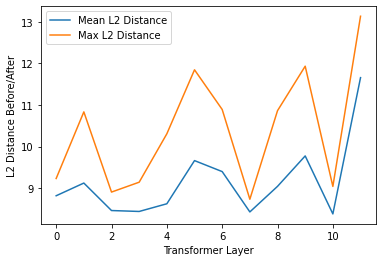

In [24]:
test = foo.stimulus_df.iloc[55]
print(test.transformer_tokens_in_tr)

plt.plot(test["activation_layerwise_mean_l2"], label="Mean L2 Distance")
plt.plot(test["activation_layerwise_max_l2"], label="Max L2 Distance")
plt.xlabel("Transformer Layer")
plt.ylabel("L2 Distance Before/After")
plt.legend(loc='best')
# plt.ylim(0, 15)

In [25]:
foo.stimulus_df.columns

Index(['tr', 'start_ts', 'end_ts', 'tr.1', 'tokens', 'n_tokens', 'tr_shift',
       'prev_tr', 'attentions', 'attentions_transformer_tokens', 'activations',
       'transformer_tokens_in_tr', 'n_transformer_tokens_in_tr',
       'masked_attentions', 'attention_heads_L1', 'attention_heads_L2',
       'attention_heads_Linf', 'coref_mag',
       'activation_end_to_end_l2_distances', 'activation_end_to_end_mean_l2',
       'activation_end_to_end_max_l2', 'activation_layerwise_l2_distances',
       'activation_layerwise_mean_l2', 'activation_layerwise_max_l2'],
      dtype='object')

In [26]:
foo.stimulus_df["mean_activation"] = foo.mean_tr_response_across_tokens()
mean_activations = foo.layerwise_rsms_from_vectors(foo.stimulus_df.mean_activation)

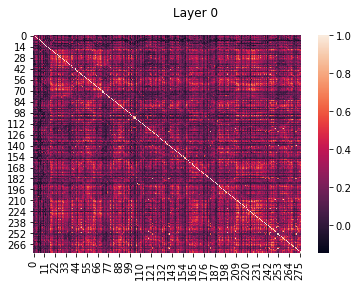

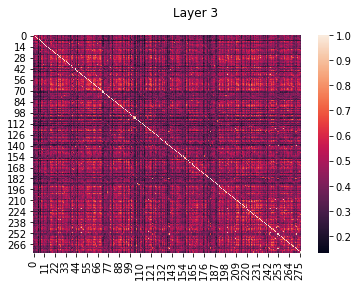

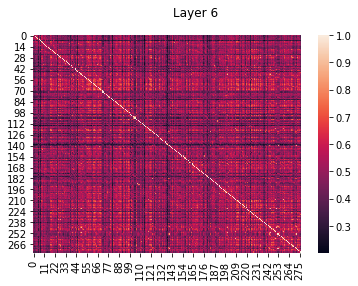

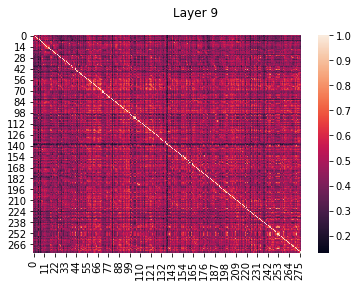

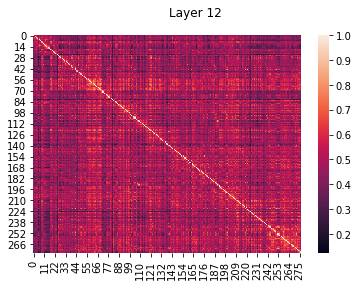

In [27]:
for i, layer in enumerate(mean_activations):
    if i%3 == 0:
        plt.figure()
        sns.heatmap(layer)
        plt.suptitle("Layer {}".format(i))

In [28]:
foo.process_stimulus_attentions(num_window_tokens=20)

In [29]:
baz = foo.mask_all_forward_attentions(7)

AttributeError: 'TransformerRSM' object has no attribute 'mask_all_forward_attentions'

In [ ]:
len(baz)

In [ ]:
len(foo.stimulus_df)

In [ ]:
import pandas as pd
import seaborn as sns

tr_idx = 5
layer_idx = 6
head_idx = 3

sns.heatmap(pd.DataFrame(baz[tr_idx][layer_idx][0][head_idx].detach().numpy()),vmin=0,vmax=.5)

In [ ]:
sns.heatmap(pd.DataFrame(foo.tr_attentions_array[tr_idx][layer_idx][0][head_idx].detach().numpy()),vmin=0,vmax=.5)

In [ ]:
inf_norm_magnitude = foo.attention_head_magnitudes(baz)
rsm_df = pd.DataFrame(np.corrcoef(inf_norm_magnitude))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df, vmin=0, vmax=1)
plt.suptitle("RSM for L-inf norm on attention heads");

In [ ]:
l2_norm_magnitude = foo.attention_head_magnitudes(baz, p=2)
rsm_df = pd.DataFrame(np.corrcoef(l2_norm_magnitude))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df, vmin=0, vmax=1)
plt.suptitle("RSM for L2 norm on attention heads");

In [ ]:
l1_norm_magnitude = foo.attention_head_magnitudes(baz, p=1)
rsm_df = pd.DataFrame(np.corrcoef(l1_norm_magnitude))

plt.figure(figsize=(8,8))
sns.heatmap(rsm_df, vmin=0, vmax=1)
plt.suptitle("RSM for L1 norm on attention heads");

In [ ]:
import numpy as np
import matplotlib.pylab as plt



In [ ]:
for layer in range(0, len(all_attentions)):
    for head in range(0, len(all_attentions[layer][0])):
        
        all_attentions[layer][0][head] = foo.mask_head_attention(all_attentions[layer][0][head], 5)
        
head_view(all_attentions, tokens)

In [ ]:
import seaborn as sns

# masked = mask_head_attention(all_attentions[1][0][0], 5)

masked = all_attentions[4][0][3]
sns.heatmap(pd.DataFrame(masked.detach().numpy()), xticklabels=tokens, yticklabels=tokens)

In [ ]:
torch.norm(masked,p=float("inf"))

In [ ]:
torch.norm(masked, p='fro')

In [ ]:


all_attentions[0][0][0].shape

In [ ]:
print(all_attentions[0][0][0])

In [ ]:
# all_attentions[0][0][0][0] = 0
all_attentions[0][0][0]

### Extracting Attention Weights

From: https://huggingface.co/transformers/model_doc/bert.html#bertmodel

**attentions**: Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

In [ ]:
coref_head = all_attentions[4][0][3]

print(coref_head.shape)

# Look at the references for the two co-referent words:
print("\"Negotiations\" attention weights: \n{}".format("\n".join(["\t{}".format(t) for t in coref_head[-3].detach().numpy()])))

print("\n\"Talks\" attention weights: \n\t{}".format("\n".join(["\t{}".format(t) for t in coref_head[3].detach().numpy()])))

In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

## Javascript Error?

If you get `Javascript Error: require is not defined`:

https://github.com/jessevig/bertviz/issues/53

In [ ]:
sentence = "joining peace talks between Israel and the Palestinians. The negotiations are"

inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)    

all_hidden_states, all_attentions = model(input_ids)[-2:]

In [ ]:
data = open("../data/greeneyes.txt").read()

In [ ]:
data[:400]

In [ ]:
inputs = tokenizer.encode_plus(data, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)    

In [ ]:
attention_and_tokens_list = []

for i in range(10, 200, 20):
    
    # define lookback window of 30 tokens
    window_start = max(0, i - 5)
    
    # Reach into the IDs tensor and grab the slice we want
    token_ids_to_process = input_ids[0][window_start:i]
    
    # Go back and get the actual tokens that correspond to those IDs
    tokens = tokenizer.convert_ids_to_tokens(token_ids_to_process.tolist())
    
    # Run the IDs through the model (need to reshape back to 1xtokens tensor)
    attentions = model(token_ids_to_process.reshape(1, -1))[-1]
    
    print(attentions[0].shape)
    
    # Append the attention weights and the tokens to our list
    attention_and_tokens_list.append((attentions, tokens))
    

In [ ]:
attentions, tokens = attention_and_tokens_list[0]

head_view(attentions, tokens)

In [ ]:
import pandas as pd
pd.DataFrame(attentions[0][0][0].detach().numpy())

In [ ]:
attentions[0].shape